# Assignment 3. Coding 1 by [Rufaim](https://github.com/Rufaim)

---

Baird’s counterexample. 
Consider the episodic seven-state, two-action MDP shown in Figure 11.1 in Sutton and Barto.
The MDP consists of 6 non-terminal states and 1 terminal state. 
The dashed action takes the system to one of the six upper states with equal probability, whereas the solid action takes the system to the seventh state.
The behavior policy b selects the dashed and solid actions with probabilities $^6/_7$ and $^1/_7$, so that the next-state distribution under it is uniform (the same for all non-terminal states), which is also the starting distribution for each episode.
The target policy $\pi$ always takes the solid action, and so the on-policy distribution (for $\pi$) is concentrated in the seventh state.
The reward is zero on all transitions.
The discount rate $\gamma$ is 0.99.
Consider estimating the state-value under the linear parameterization indicated by the expression shown in each state circle in Fig 11.1 in Sutton and Barto.

Implement the Semi-gradient TD(0) algorithm for this MDP.
The goal here is to perform policy evaluation: that is, to estimate the value function of the policy being followed.
The value of each state is to be approximated as a linear combination of features.

#### References

 1. Sutton, Richard S and Andrew G Barto (2018). Reinforcement learning: An introduction. MIT press.
 2. Baird, Leemon (1995). “Residual algorithms: Reinforcement learning with function approximation”. In: Machine Learning Proceedings 1995. Elsevier, pp. 30–37.

## Imports and Global constants

In [0]:
import numpy as np
import matplotlib.pyplot as pyplot
import matplotlib.colors as mcolors

Default parameters are:
```python
GAMMA = 0.99
NUM_TRIALS = 100
NUM_EPISODES = 1000
SEED = 42
```

In [0]:
GAMMA = 0.99
NUM_TRIALS = 100
NUM_EPISODES = 1000
SEED = 42

## Environment

Baidu's Conter example is a MDP with seven states.
Agent can take two actions at each state. Action number one takes agent to one of the first six states (picked randomly), while action  number two takes agent to the seventh state.

In [0]:
class BairdCounterexample(object):
    def __init__(self,seed=None):       
        self._states = np.zeros((7,8))
        self._states[:,-1] = 1
        self._states.flat[::self._states.shape[0]+2] = 2
        self._states[-1,-2:] = [1,2]
        self._random_generator = np.random.RandomState(seed=seed)
    def reset(self):
        self.current_state = self._random_generator.randint(7)
        return self._states[self.current_state]
    def step(self,action):
        if action == 1:
            self.current_state = 6
            return self._states[self.current_state], 0
        else:
            self.current_state = self._random_generator.randint(6)
            return self._states[self.current_state], 0

## Agents

We are testing two agents: On- and Off-policy. In both cases we follow behavior policy $b$ that takes first action with probability $^6/_7$ and second action with probability $^1/_7$. However in on-policy case we are optimizing weigths following behaviour policy (in other words we estimating the value function undder policy $b$) while in off-policy case we are also considering target policy that always takes the second actions.

In [0]:
class Agent(object):
    def __init__(self,gamma=1.0,learning_rate=0.01,seed=None):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self._base_prob = 1/7
        self._random_generator = np.random.RandomState(seed=seed)
        self.init_weigths()
    def get_action(self):
        action = self._random_generator.binomial(1, self._base_prob)
        rho = 0 if action==0 else 1/self._base_prob
        return action, rho
    def value_function(self,state):
        return state.dot(self.weigths)
    
    def update(self,state,action,reward,state_):
        raise NotImplemented
    def init_weigths(self):
        raise NotImplemented

### Semi-gradient on-policy TD(0)
Our first test subject is on-policy Time-Difference algorithm where weights are optimized with gradients in the direction of one-step advantage (denoted as $\delta$).

*Algorithm:*

$
\text{For each episode:} \\
\quad\text{Initialize s}\\
\quad\text{Until S is terminal:} \\
\quad\quad\text{Choose } A \sim \pi(\cdot | S)\\
\quad\quad\text{Take action } A \text{ and observe reward } R \text{ and next state } S'\\
\quad\quad \delta \leftarrow R + \gamma \hat{v}(S';w) - \hat{v}(S;w)\\
\quad\quad w \leftarrow w + \alpha\delta \nabla \hat{v}(S;w) \\
\quad\quad S \leftarrow S'
$

In [0]:
class OnPolicyAgent(Agent):
    def update(self,state,action,reward,state_,rho):
        delta = reward + self.gamma*self.value_function(state_) - self.value_function(state)
        self.weigths += self.learning_rate*delta*state
    def init_weigths(self):
        self.weigths = self._random_generator.normal(0,0.5,size=(8,))

### Semi-gradient off-policy TD(0)

For off-policy alogorithm we rewrite update rule for weigths:

$
w \leftarrow w + \alpha\delta \rho \hat{v}(S;w),
$
where $\rho = \frac{\pi(A|S)}{b(A|B)}$ and $b$ is a choosen baseline policy.

weigths here are initialize according to Baidu's experiment instructions.

In [0]:
class OffPolicyAgent(Agent):
    def update(self,state,action,reward,state_,rho):
        delta = reward + self.gamma*self.value_function(state_) - self.value_function(state)
        self.weigths += self.learning_rate*delta*rho*state
    def init_weigths(self):
        self.weigths = np.array([1, 1, 1, 1, 1, 1, 10, 1],dtype=np.float)

## Test Framework

To reproduce Baidu experiment we perform learning and record weigths. 
We expect that weigths for on-policy TD will converge while off-policy TD weigths diverge.

In [0]:
class TestFrameworkLite(object):
    '''Here is the lighter version of our standard test framwork.
    Since there is not much to record we got rid of run_episode step.
    '''
    def __init__(self,env_builder,agent_builder,
                 num_steps,num_trials,masterseed=None):
        self.env_builder = env_builder      #input: seed
        self.agent_builder = agent_builder  #input: lr,seed
        self.num_steps = num_steps
        self.num_trials = num_trials
        self.masterseed = masterseed

        self.reset()
    
    def reset(self):
        self._random_generator = np.random.RandomState(self.masterseed)

    def run_trial(self,env,agent):
        ws = np.zeros((self.num_steps, agent.weigths.shape[0]))
        s = env.reset()
        for i in range(self.num_steps):
            a, rho = agent.get_action()
            s_,r = env.step(a)
            agent.update(s,a,r,s_,rho)

            s = s_
            ws[i,:] = agent.weigths.copy()
        return ws

    def run_experiment(self,learning_rate):
        seeds = self._random_generator.randint(0,1000000, size=self.num_trials)
        weigths = np.zeros((self.num_trials, self.num_steps,8))

        for trial in range(self.num_trials):
            env = self.env_builder(seeds[trial])
            agent = self.agent_builder(learning_rate,seeds[trial])
            print("\rTrial # {} of {}".format(trial+1,self.num_trials),end="")
            weigths[trial,:,:] = self.run_trial(env,agent)
        print()
        return weigths


## Experiments

In the following experiments we are looking on weights. Weigths are expected to converge while on-policy and diverge under off-policy learaning with our spetial settings.

### On Policy

For the first experiment we run on-policy learning several times with differend learning rates to show that algorithm tends to converge with any of hyperparameters.

In [0]:
agent_builder = lambda lr,seed: OnPolicyAgent(learning_rate=lr,seed=seed)
test_framework = TestFrameworkLite(BairdCounterexample,agent_builder,NUM_EPISODES,NUM_TRIALS,SEED)

In [9]:
weigths_on_1 = test_framework.run_experiment(0.1)
w_on_1 = np.mean(weigths_on_1,axis=0)

Trial # 100 of 100


In [10]:
test_framework.reset()
weigths_on_2 = test_framework.run_experiment(0.01)
w_on_2 = np.mean(weigths_on_2,axis=0)

Trial # 100 of 100


In [11]:
test_framework.reset()
weigths_on_3 = test_framework.run_experiment(0.001)
w_on_3 = np.mean(weigths_on_3,axis=0)

Trial # 100 of 100


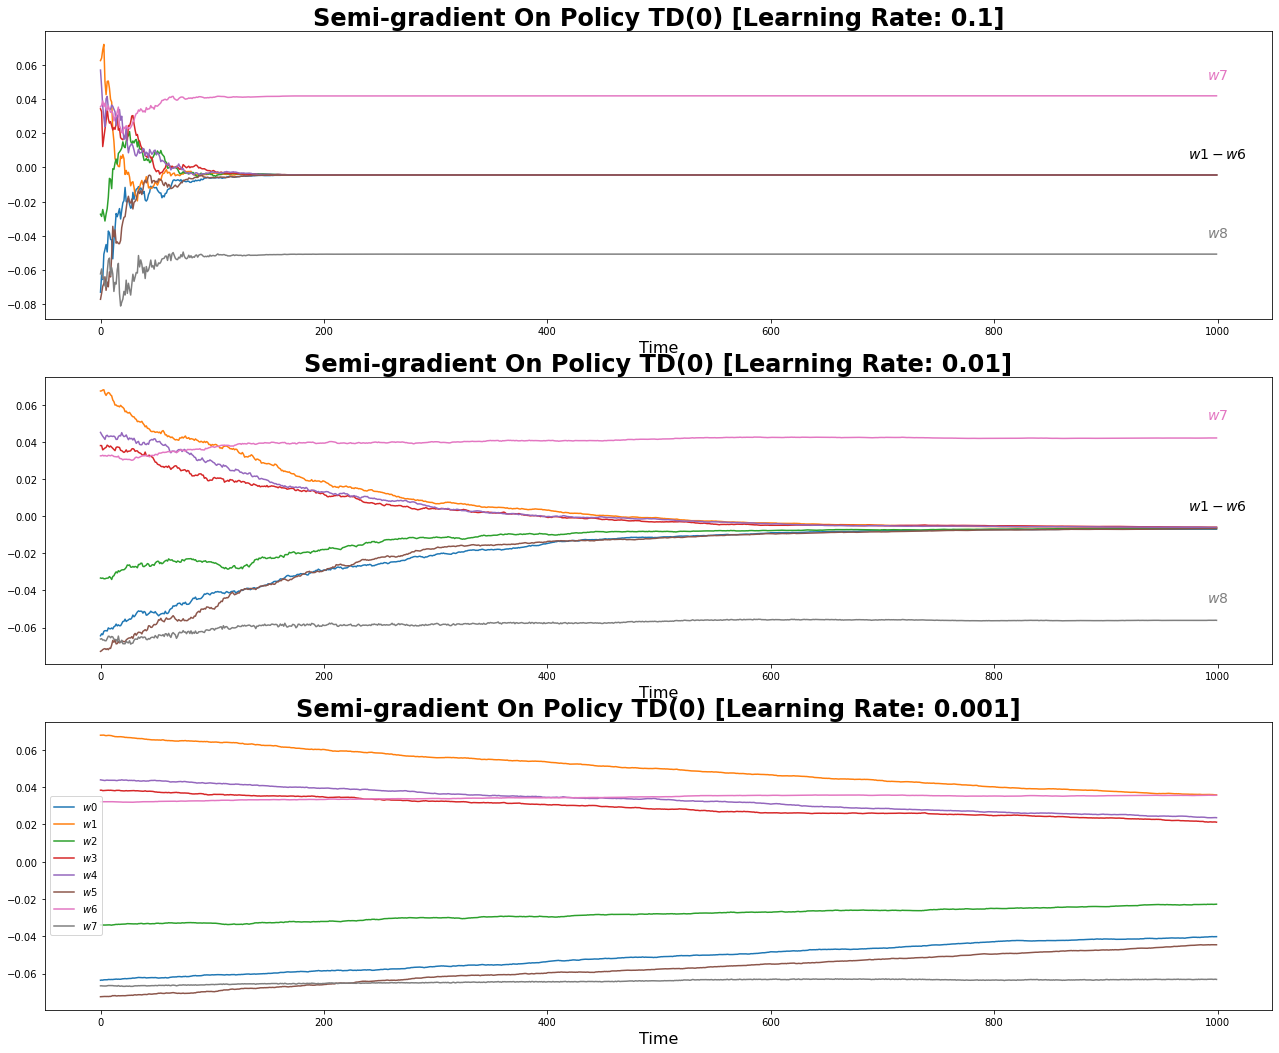

In [12]:
fig, [ax1,ax2,ax3] = pyplot.subplots(nrows=3,figsize=(22,18))
l1 = ax1.plot(w_on_1)
ax1.set_title("Semi-gradient On Policy TD(0) [Learning Rate: 0.1]", fontsize=24, fontweight="bold")
ax1.set_xlabel("Time", fontsize=16)
ax1.text(1000, w_on_1[-1,6]+0.01,"$w7$", fontsize=14,ha="center",c=l1[6].get_color())
ax1.text(1000, w_on_1[-1,7]+0.01,"$w8$", fontsize=14,ha="center",c=l1[7].get_color())
ax1.text(1000, w_on_1[-1,0]+0.01,"$w1-w6$", fontsize=14,ha="center")

l2 = ax2.plot(w_on_2)
ax2.set_title("Semi-gradient On Policy TD(0) [Learning Rate: 0.01]", fontsize=24, fontweight="bold")
ax2.set_xlabel("Time", fontsize=16)
ax2.text(1000, w_on_2[-1,6]+0.01,"$w7$", fontsize=14,ha="center",c=l1[6].get_color())
ax2.text(1000, w_on_2[-1,7]+0.01,"$w8$", fontsize=14,ha="center",c=l1[7].get_color())
ax2.text(1000, w_on_2[-1,0]+0.01,"$w1-w6$", fontsize=14,ha="center")

l3 = ax3.plot(w_on_3)
ax3.set_title("Semi-gradient On Policy TD(0) [Learning Rate: 0.001]", fontsize=24, fontweight="bold")
ax3.set_xlabel("Time", fontsize=16)
ax3.legend([f"$w{i}$" for i in range(8)])

As you can see on-policy learning converges. with small learning rate it converges very slowly but surely. This is exactly the result we expected.

### Off Policy

For the second experiment we are following Baidu's conterexample. Thus we have learning rate equals to 0.01.

In [0]:
agent_builder = lambda lr,seed: OffPolicyAgent(learning_rate=lr,seed=seed)
test_framework = TestFrameworkLite(BairdCounterexample,agent_builder,NUM_EPISODES,NUM_TRIALS,SEED)

In [14]:
weigths = test_framework.run_experiment(0.01)
w = np.mean(weigths,axis=0)

Trial # 100 of 100


Text(980, 170.4665479452808, '$w1-w6$')

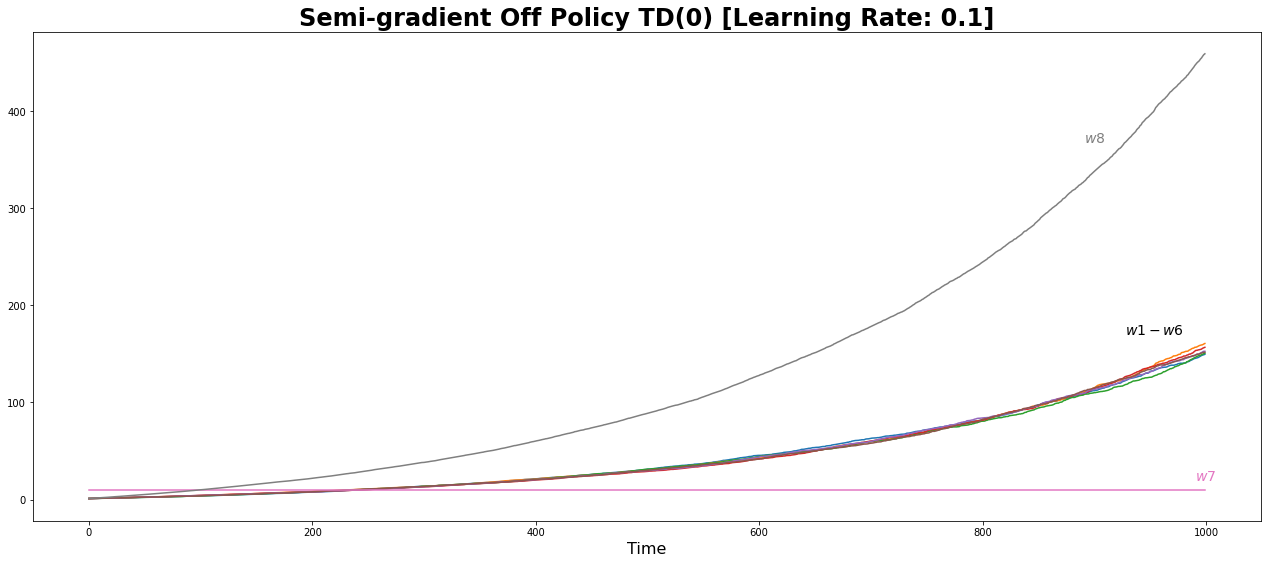

In [15]:
fig, ax = pyplot.subplots(figsize=(22,9))
l1 = ax.plot(w)
ax.set_title("Semi-gradient Off Policy TD(0) [Learning Rate: 0.1]", fontsize=24, fontweight="bold")
ax.set_xlabel("Time", fontsize=16)
ax.text(1000, w[-20,6]+10,"$w7$", fontsize=14,ha="center",c=l1[6].get_color())
ax.text(900, w[900,7]+30,"$w8$", fontsize=14,ha="center",c=l1[7].get_color())
ax.text(980, w[980,0]+30,"$w1-w6$", fontsize=14,ha="right")

Diverges as expected. As you can see all weigths components but seventh are blowing up. Espetially clear it could be seen on eighth component. That divergence is exactly what Baudu intended to see during example contruction.